# Picking the ALMA Imaging Strategy that Recovers the Most Signal for SDSS 1531

Running `alma_reduce_run_all_cleans.py` and `alma_reduce_imaging.py` will image both measurement sets (`647`, which is over-resolved because the baselines are too large and `649`, which is pretty nice without tapering). We can now use this notebook (and imported scripts) to create moment maps for each imaging strategy (part `1`) and then pick the best one for recovering the most signal (part `2`).

In [ ]:
#set path to beads folder
path_to_beads = '/Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/'

In [2]:
#system
import sys
import glob
from types import SimpleNamespace 


#astropy
import astropy.units as u
from astropy.coordinates import Angle
import astropy.constants as const

#matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

#seaborn
import seaborn as sns

#numpy
import numpy as np



In [3]:
#import modules: you can see them in all in the utils folder
util_path = path_to_beads + 'Notebooks/Beads20/utils/'
sys.path.append(util_path)

import plotting_functions as pf
import science_functions as sf

In [4]:
#General Information about SDSS 1531
about_sdss1531 = SimpleNamespace(**sf.sdss1531_dict)
print(about_sdss1531)

namespace(cz=100430.47, dec=34.2404172, name='SDSS J1531+3414', ra=232.7936938, radius=2.5, z=0.335)


### 1. Create Moment Maps for Each ALMA Imaging Option


In [6]:
#obtain all images made from image_beads_final.py

alma_data_dir = path_to_beads + 'Analysis/almaBeads/reduced_2022/'
alma_files = glob.glob(alma_data_dir + 'SDSS*pbcor.fits')

Below, we define the first (`first_channel_40`) and last channels (`last_channel_40`)) of the range of channels that have clearly detected emission in the 40 km/s cube. (Looked at this in DS9) 

Using the 40 km/s cube as a reference, we create moment maps for each velocity resolution (10, 20, 40 or 80 lm/s). 

Next, we create the moment maps using `bettermoments`[https://bettermoments.readthedocs.io/en/latest/], inputting the best parameters determined from notebook 1. The function `bm_moment_maps` has more details on how each parameter is applied, but the printed output gives the gist of what's happening.

In [17]:
#velocity channels with emission in the 40km/s cube
first_channel_40, last_channel_40 = 17, 36

#where the velocity resolution is found in the filename string
str_range = [116, 118] 

for id_afile, alma_file in enumerate(alma_files):

    #converting channels in 40km/s cube to channels to the given
    #velocity resolution of the alma_file
    
    velocity_resolution = int(alma_file[str_range[0]:str_range[1]])
    channel_range = [sf.channels_conversion(velocity_resolution, first_channel_40) , 
                        sf.channels_conversion(velocity_resolution, last_channel_40)]

    print("Creating Moment Maps for ALMA File with {}".format(alma_file[116:145]))

    #find beam size for each alma_file
    hdu, hdr, w = pf.open_fits(alma_files[0])
    beam_width = hdr['BMAJ']/hdr['CDELT2']

    #best parameters for creating moment maps found in notebook 1
    spectral_smooth_width = 2
    poly_order = 0
    sigma_clip = 3.5
    spatial_smooth_width = int(beam_width * 0.5)

    moment_type = 'all' #create mom0,1,2 and more
    
    #set chatty = False if you don't want to see the output below
    sf.bm_moment_maps(alma_file, moment_type=moment_type, fchannel=channel_range[0], 
                        lchannel=channel_range[1], kernel_width=spectral_smooth_width, 
                        smooth_poly_order=poly_order, thresh_mask_smooth=spatial_smooth_width, 
                        sigma_clip=sigma_clip, chatty=True)

    

Creating Moment Maps for ALMA File with 40kms_natural_taper_1.2arcsec
..spectrally smoothing the data with top hat kernel 2 channels wide and applying a a Savitzky-Golay filter using polynomial of order 0...
... estimating rms of the line free channels located in the first 5 and last 5 channels of the data cube
RMS = 0.154 mJy/beam (original)
RMS = 0.094 mJy/beam (smoothed)
... no user masking...
...applying a sigma clip to all pixels with SN < 3.5 sigma but we will first spatially smooth the data by 2 pixels...
... selecting channels only between 17 and 36...
...combining all masks...
... creating all moment....
all moment map created.
Creating Moment Maps for ALMA File with 10kms_briggs_notaper.image.pb
..spectrally smoothing the data with top hat kernel 2 channels wide and applying a a Savitzky-Golay filter using polynomial of order 0...
... estimating rms of the line free channels located in the first 5 and last 5 channels of the data cube
RMS = 0.350 mJy/beam (original)
RMS = 0.20

### 2. Plot Created Moments

In [19]:
#all created moments
mom0_files = glob.glob(alma_data_dir + 'SDSS*.pbcor_M0.fits')

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


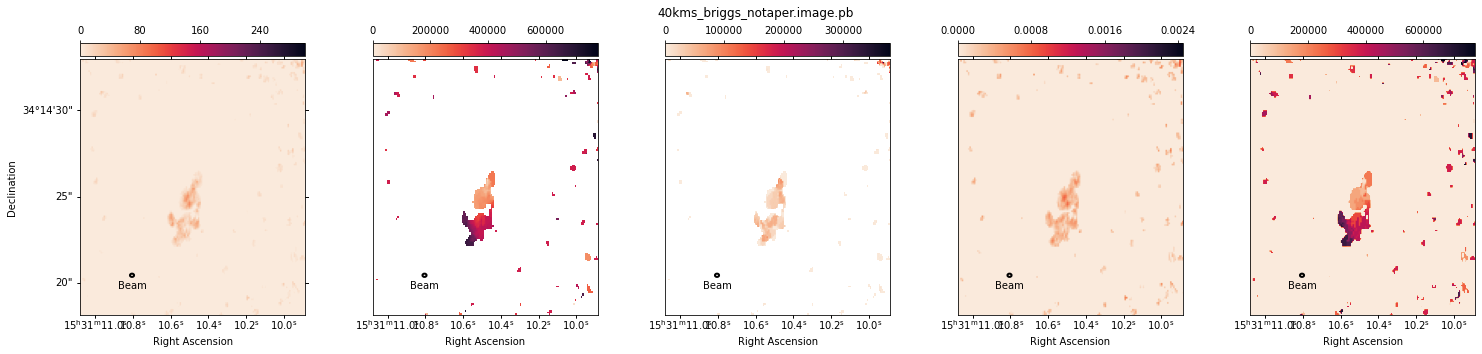

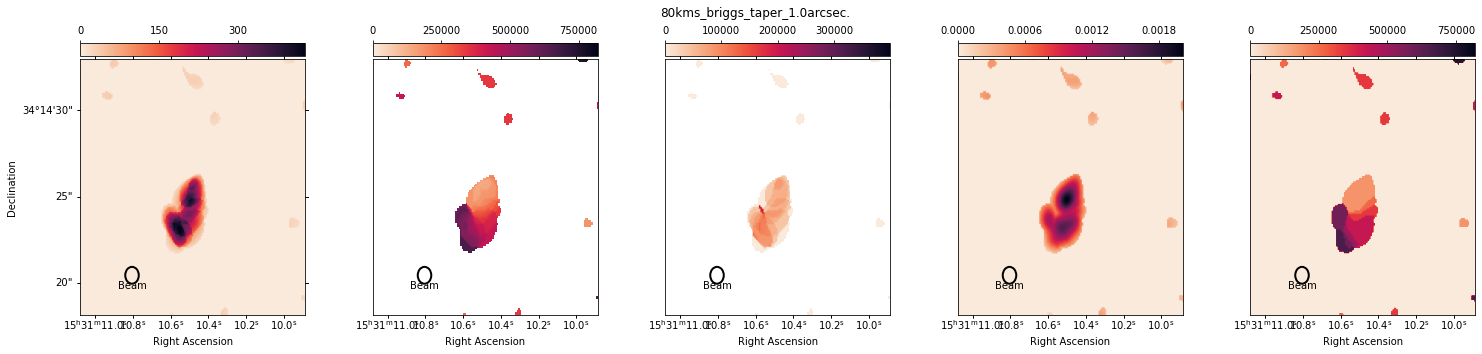

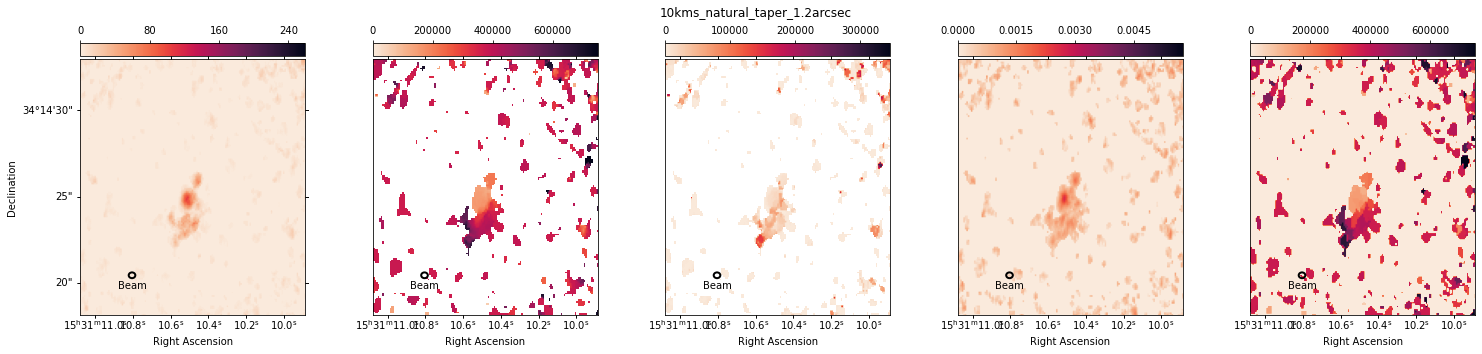

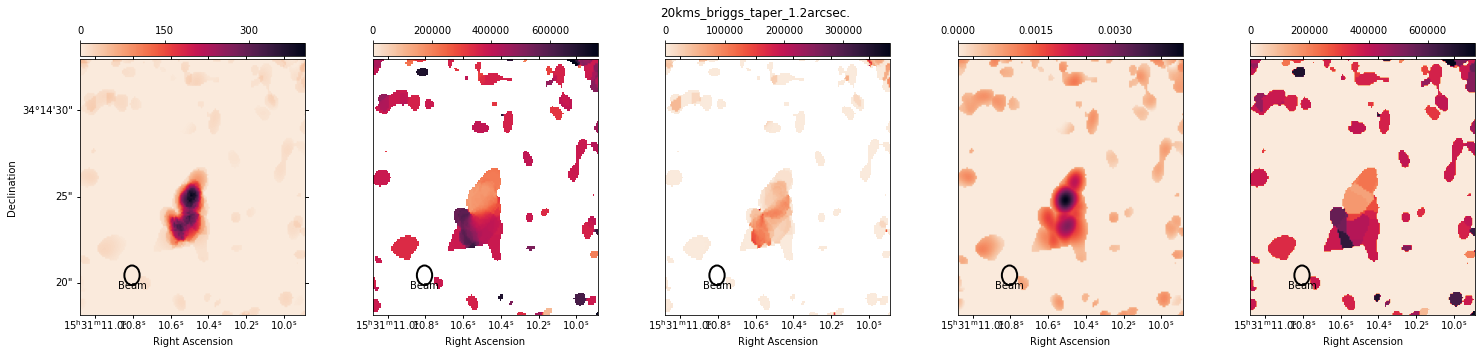

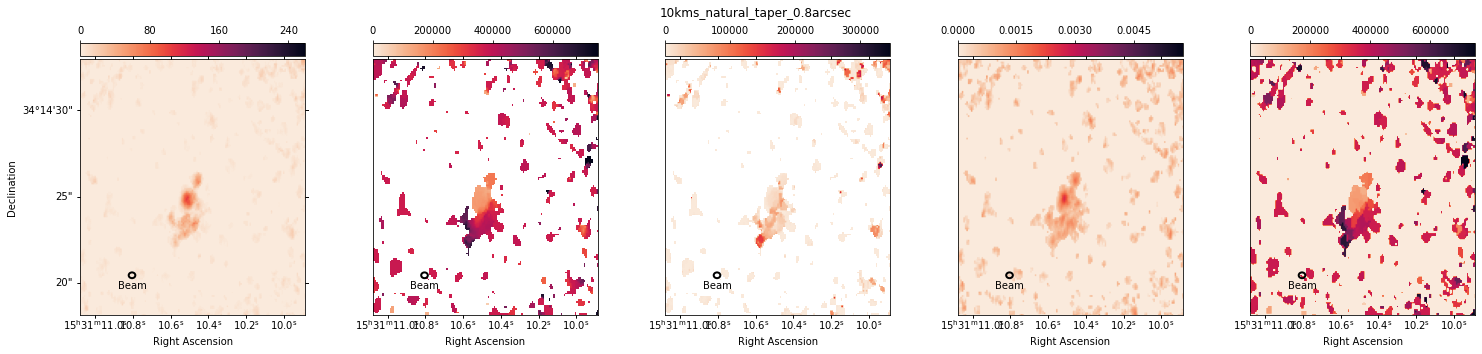

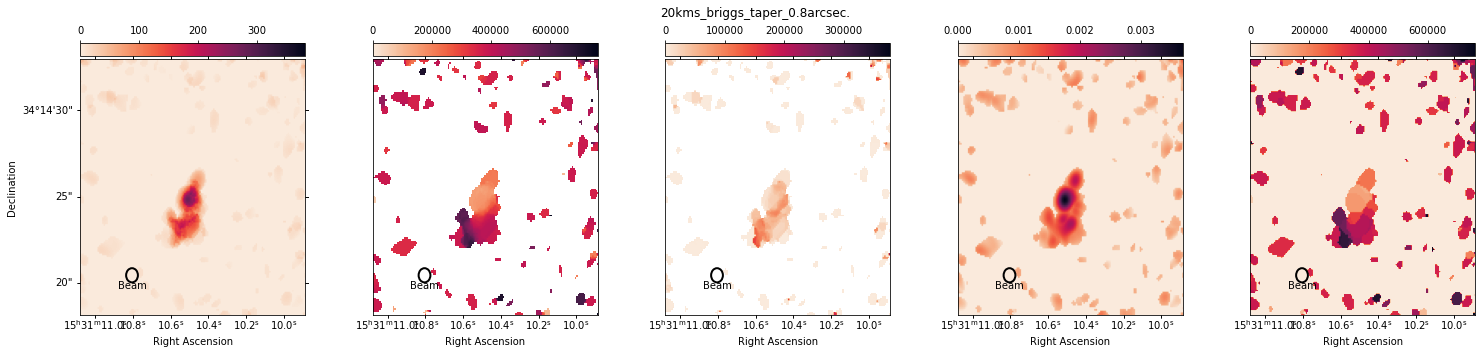

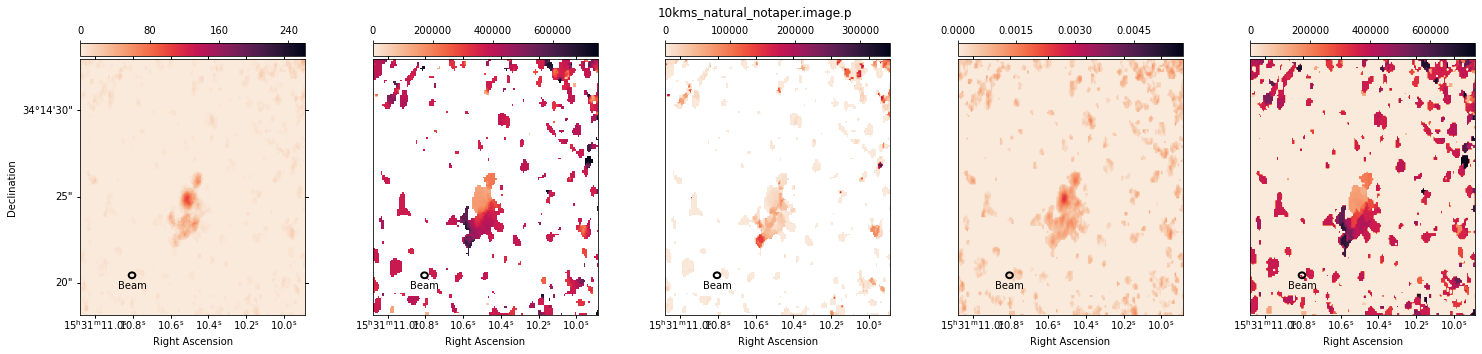

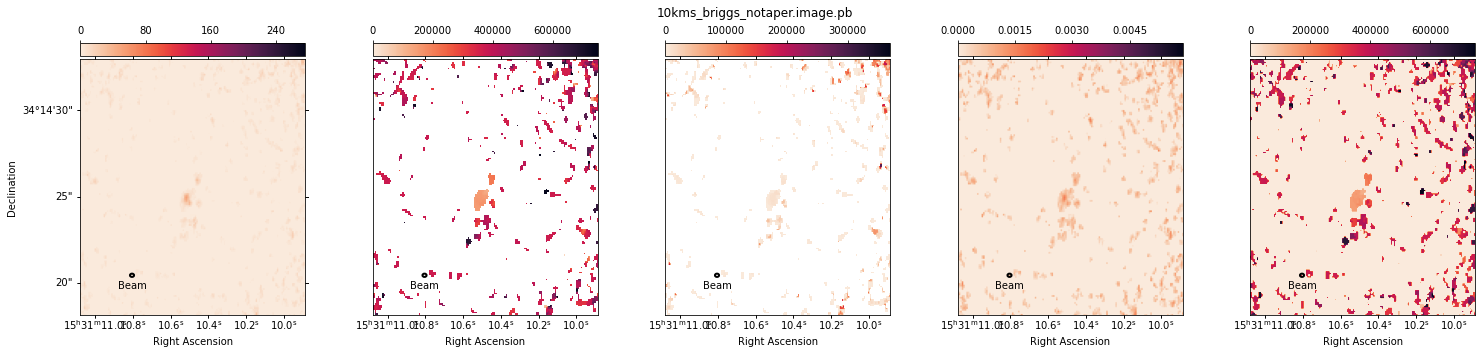

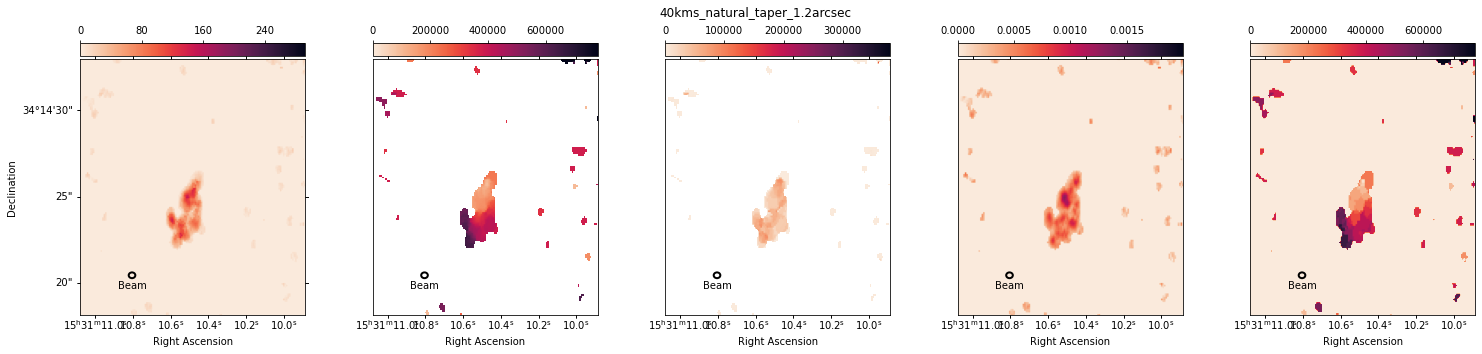

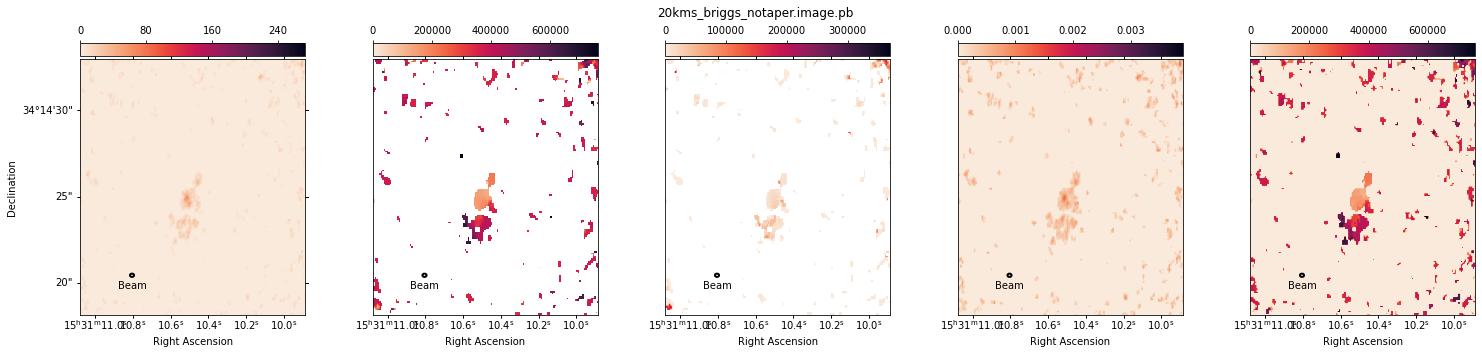

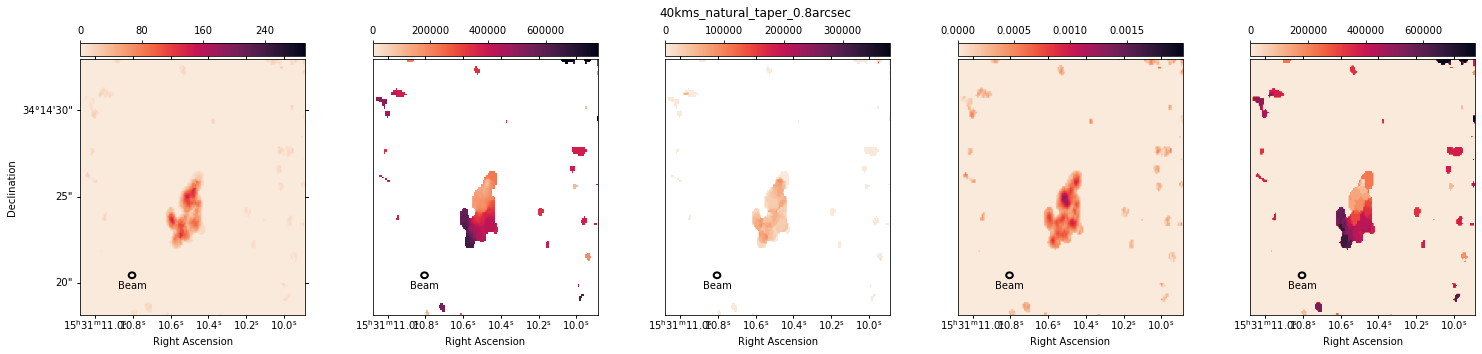

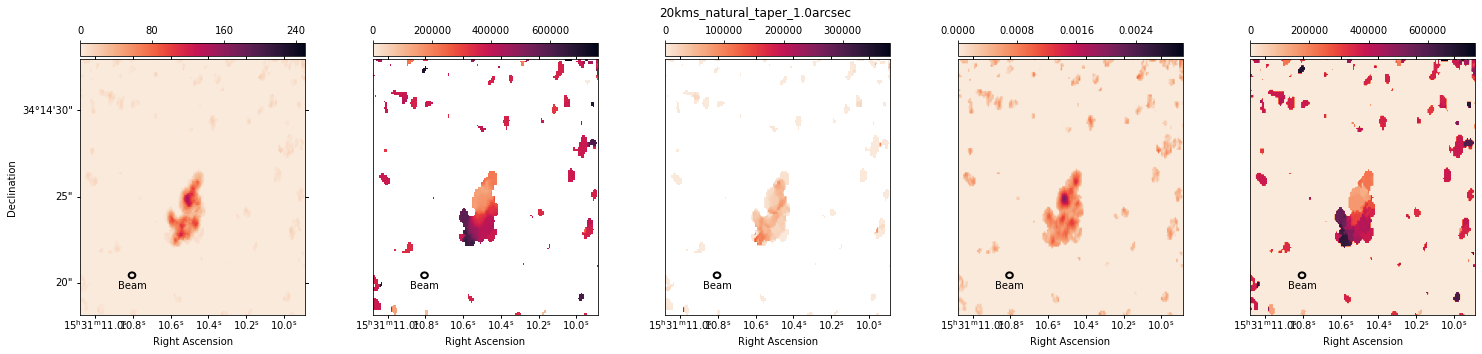

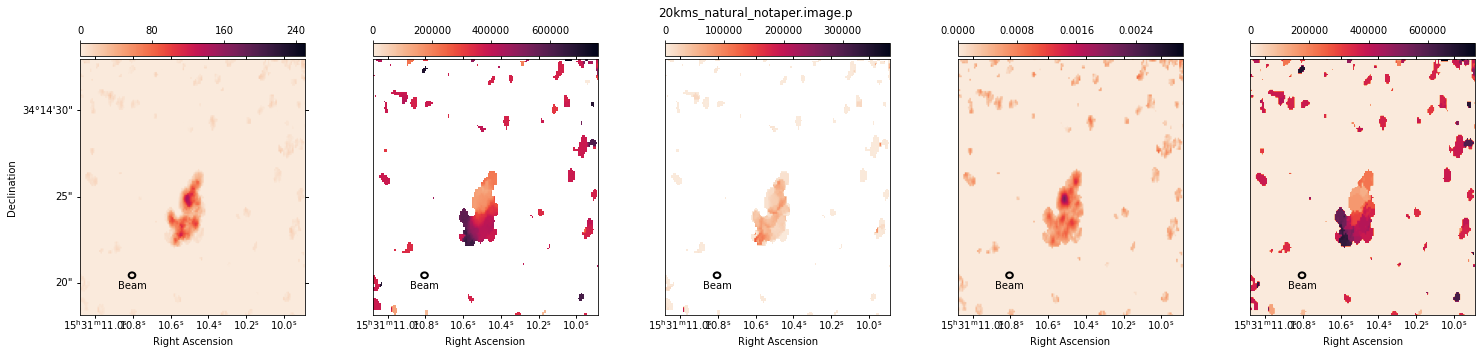

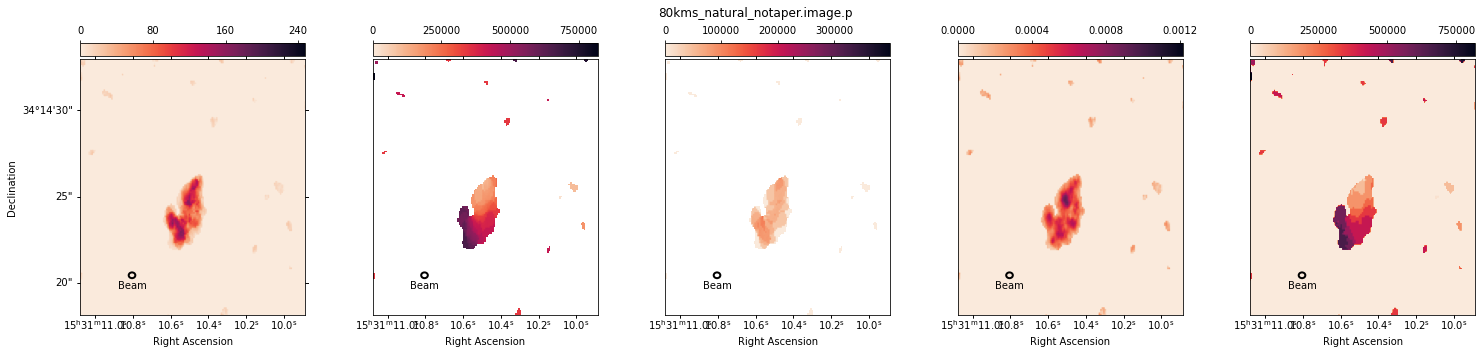

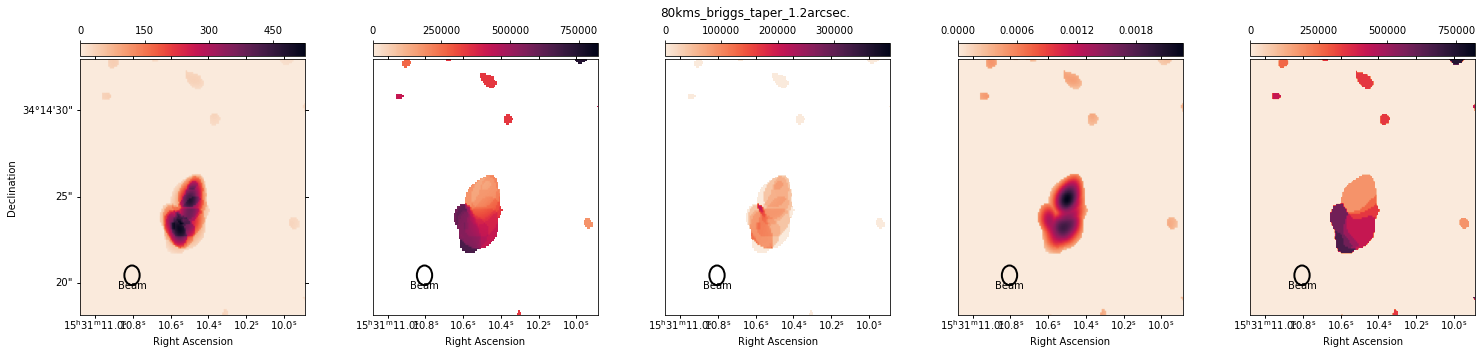

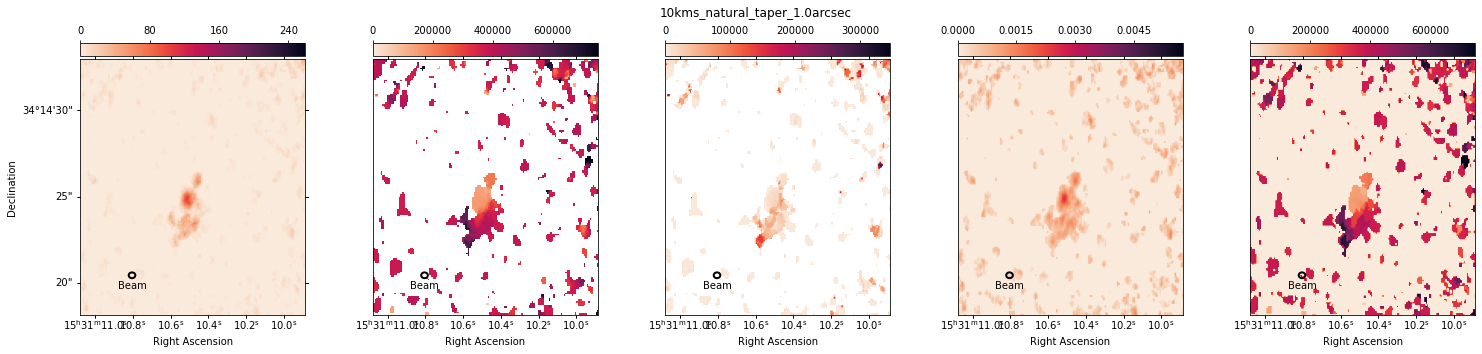

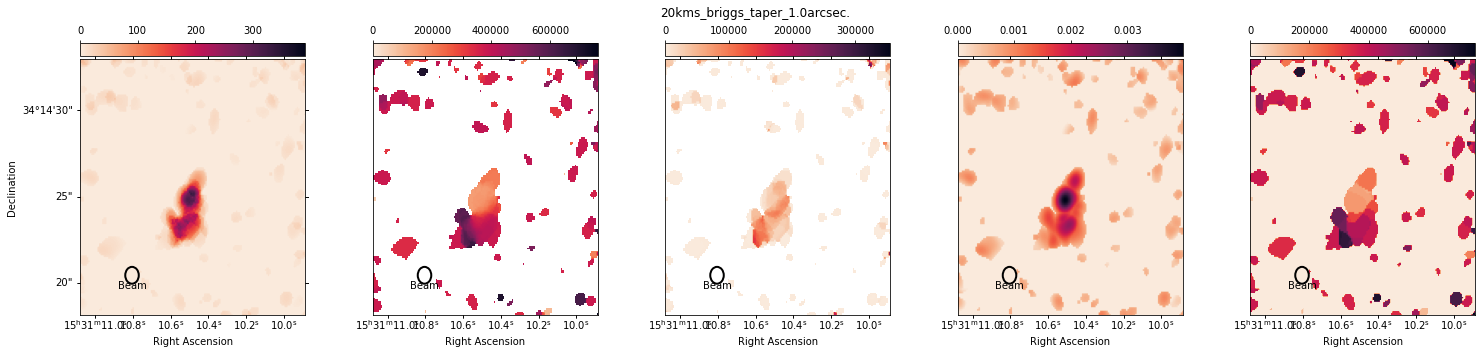

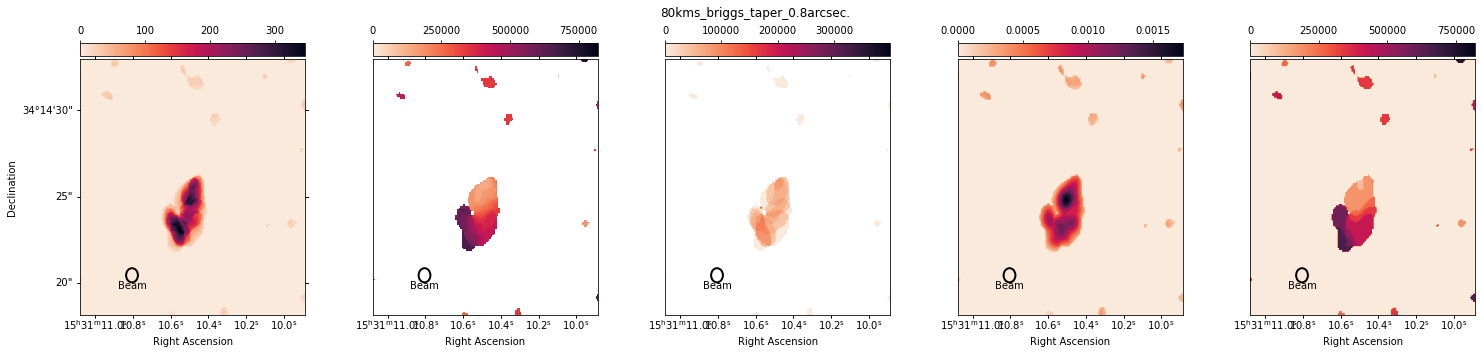

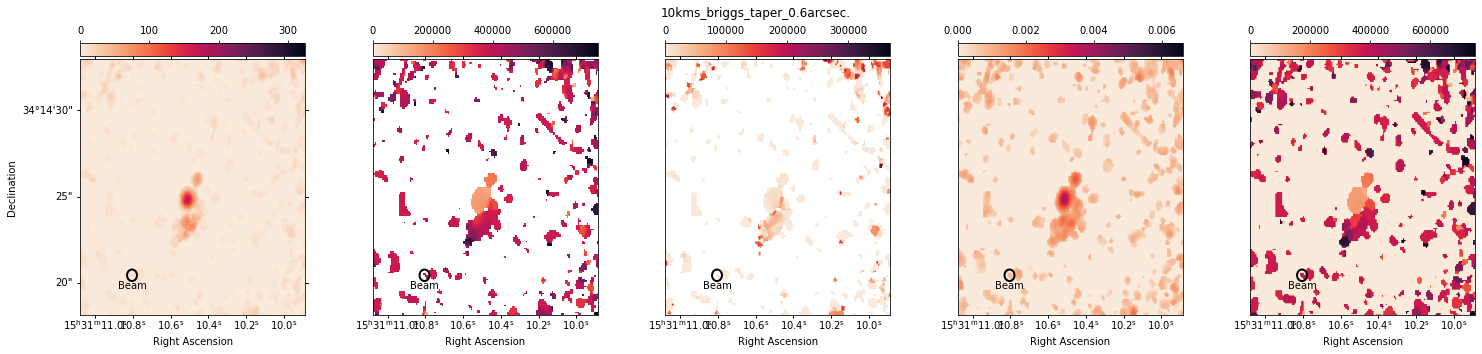

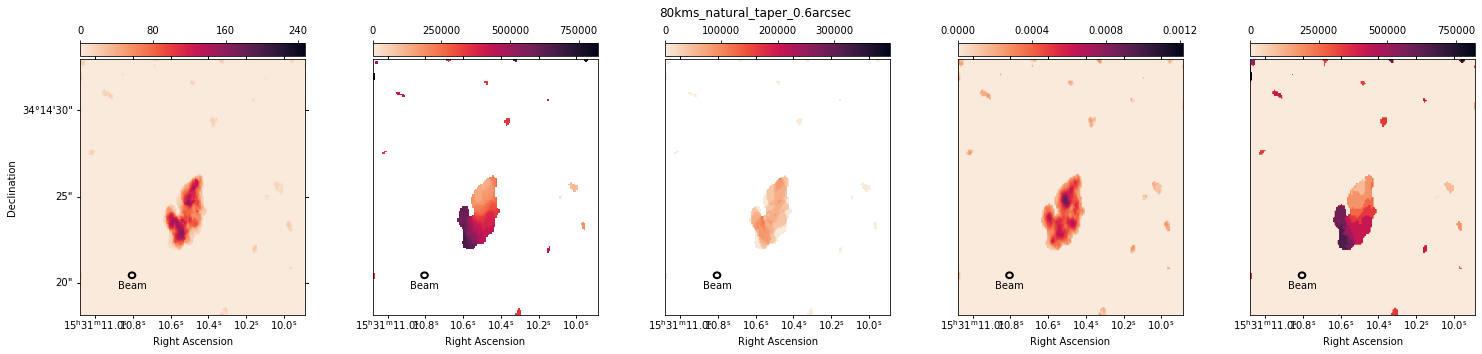

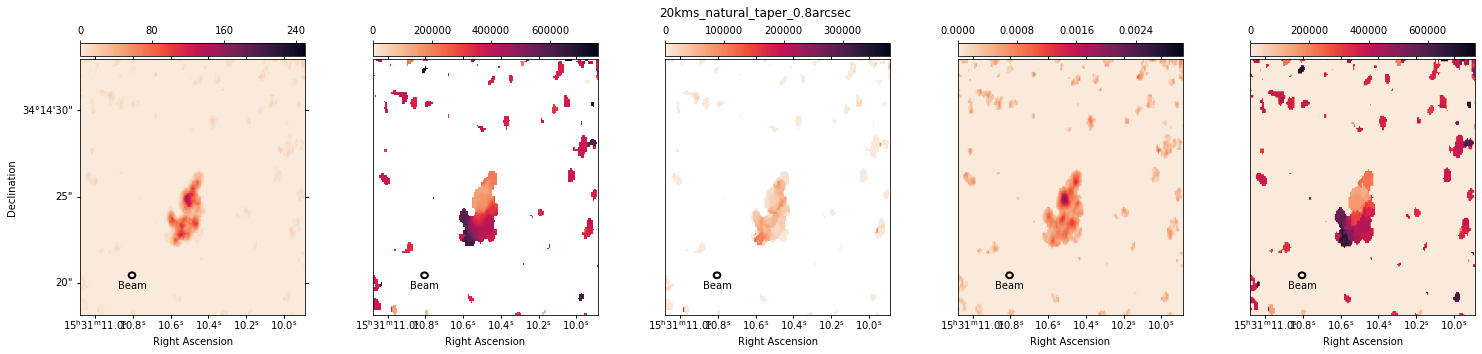

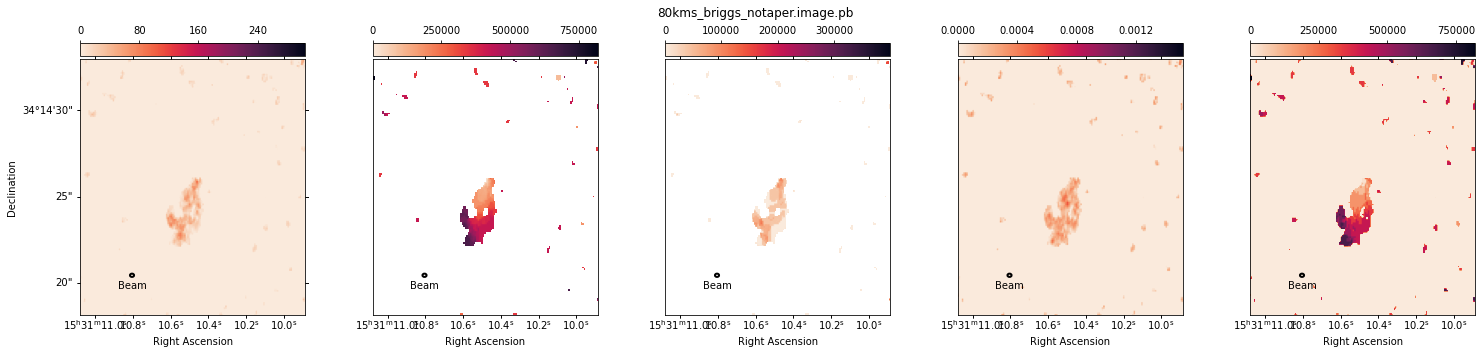

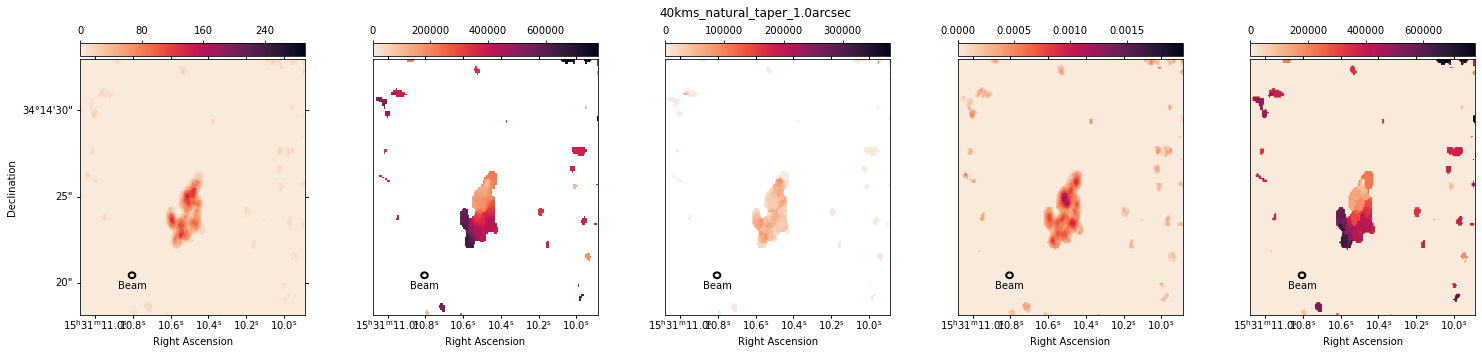

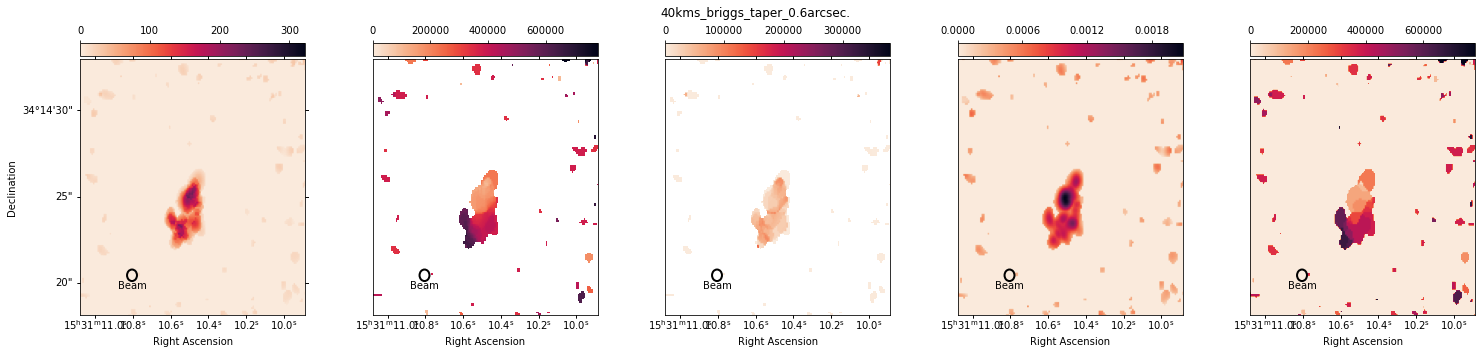

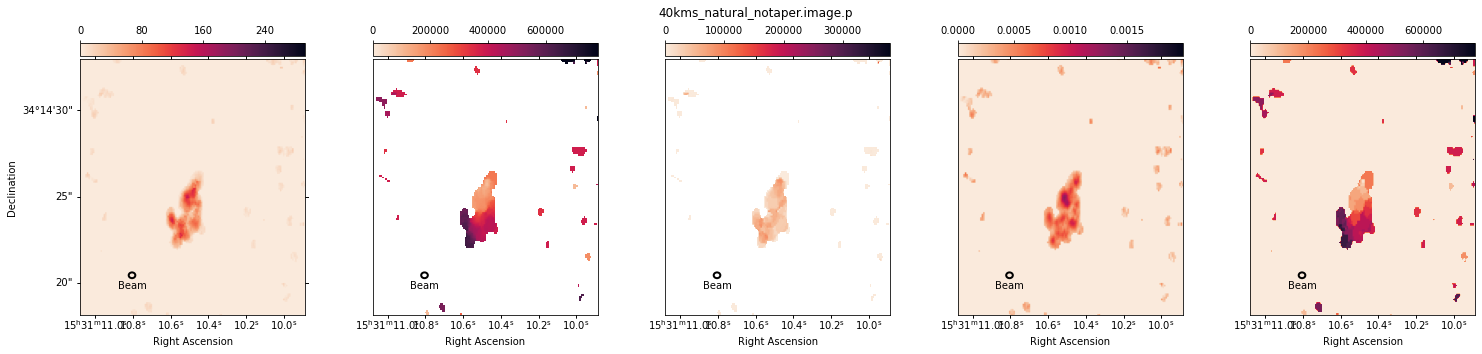

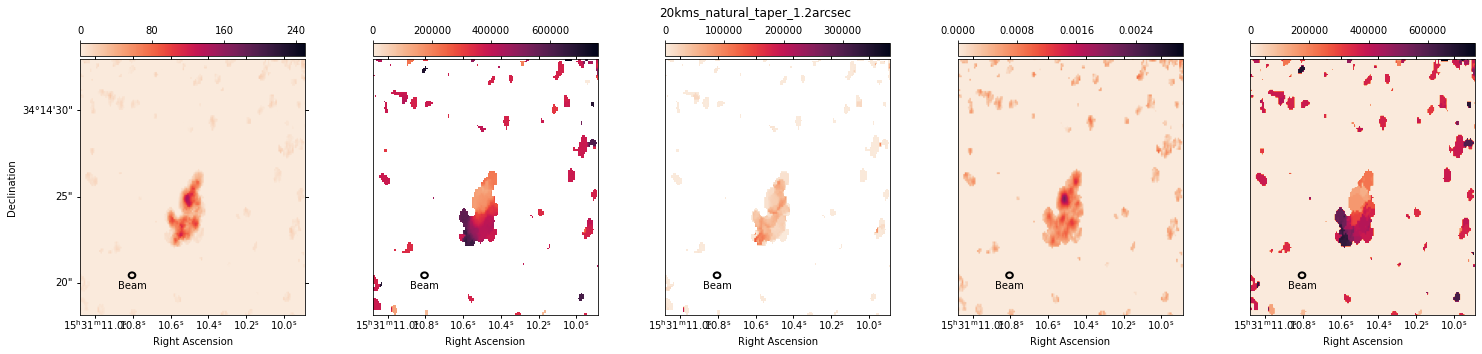

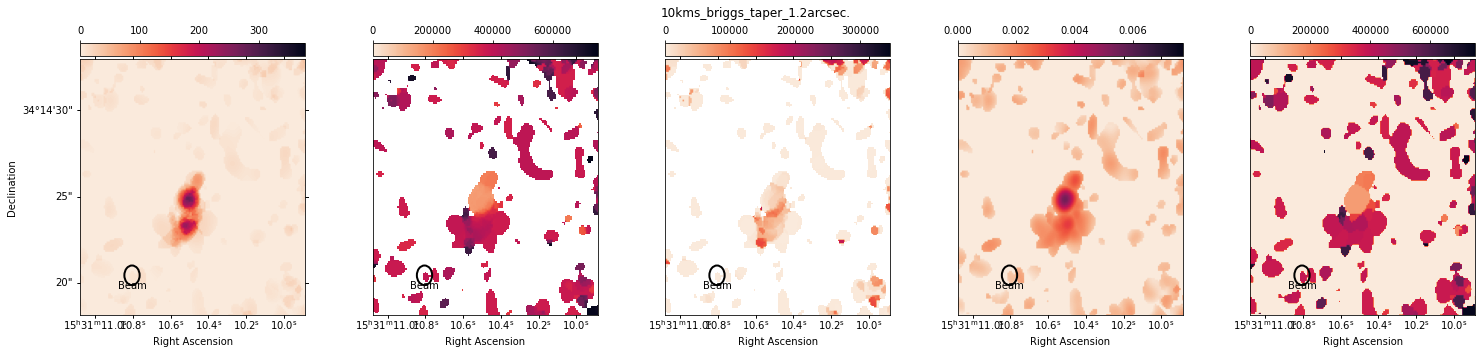

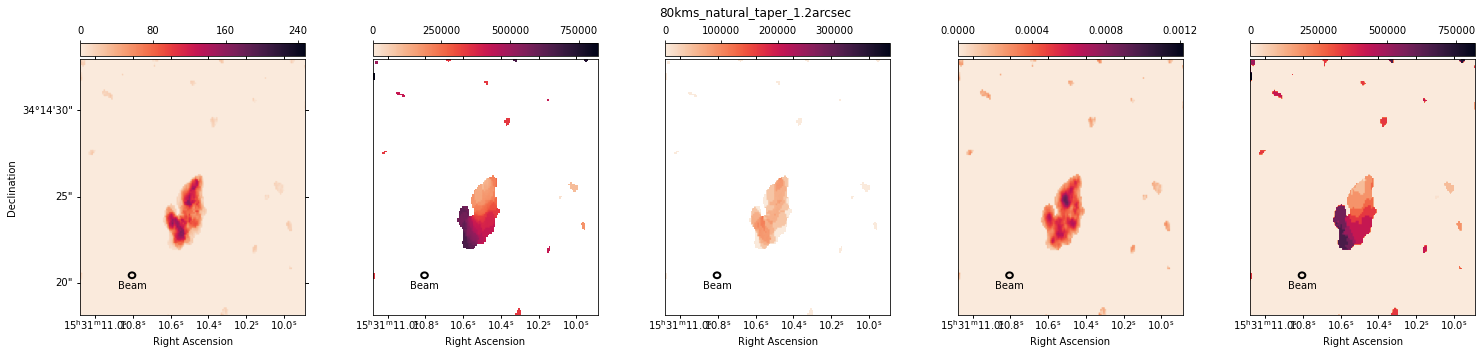

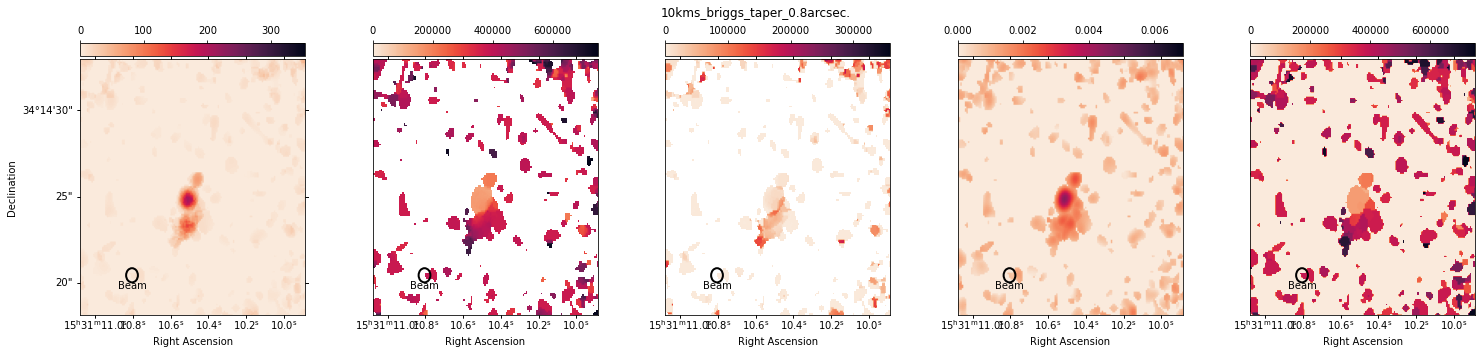

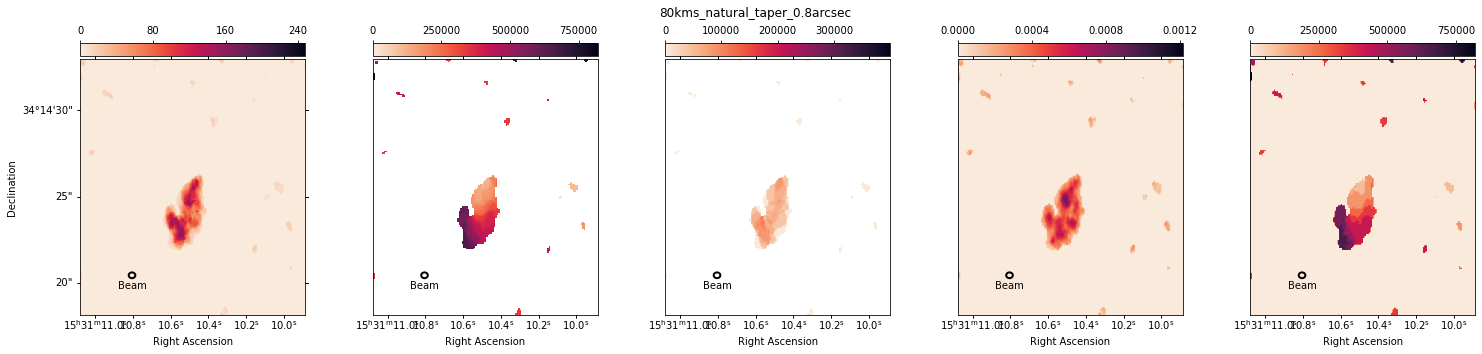

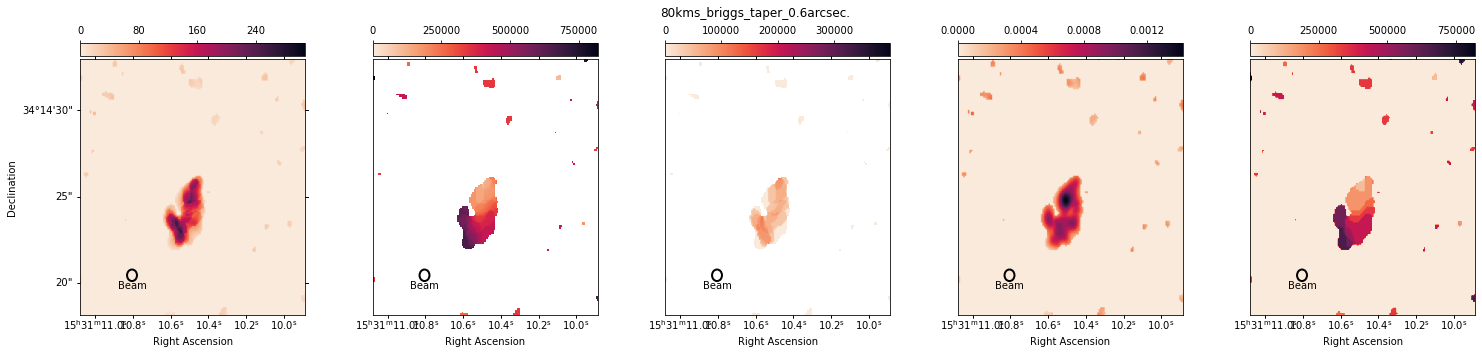

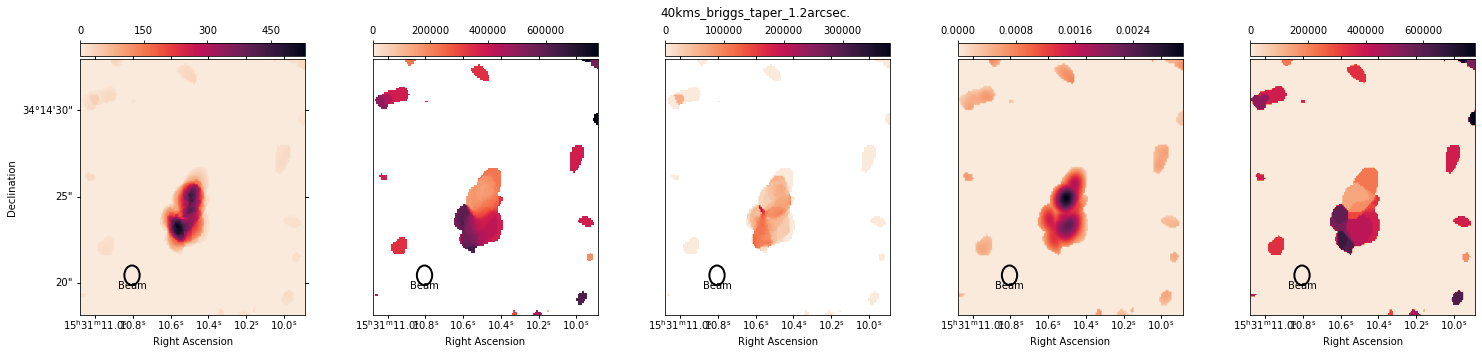

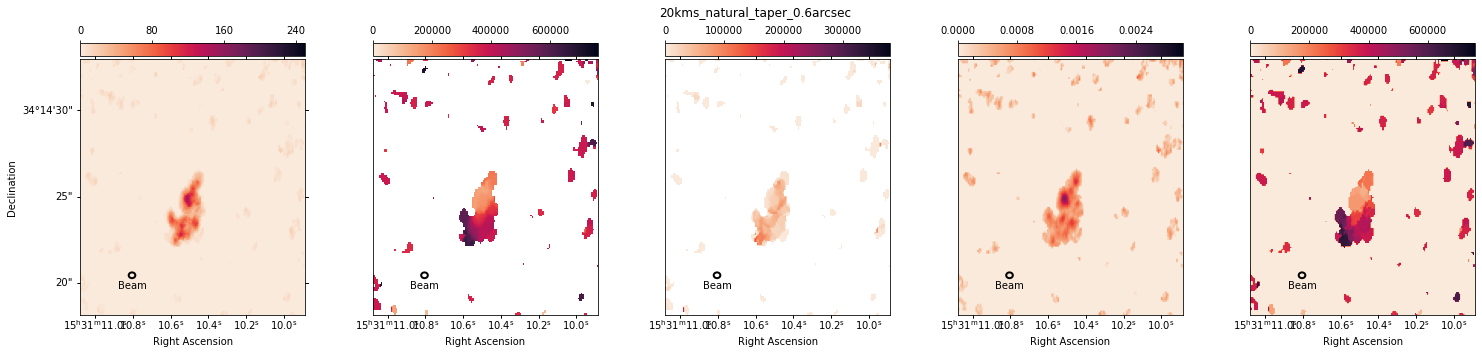

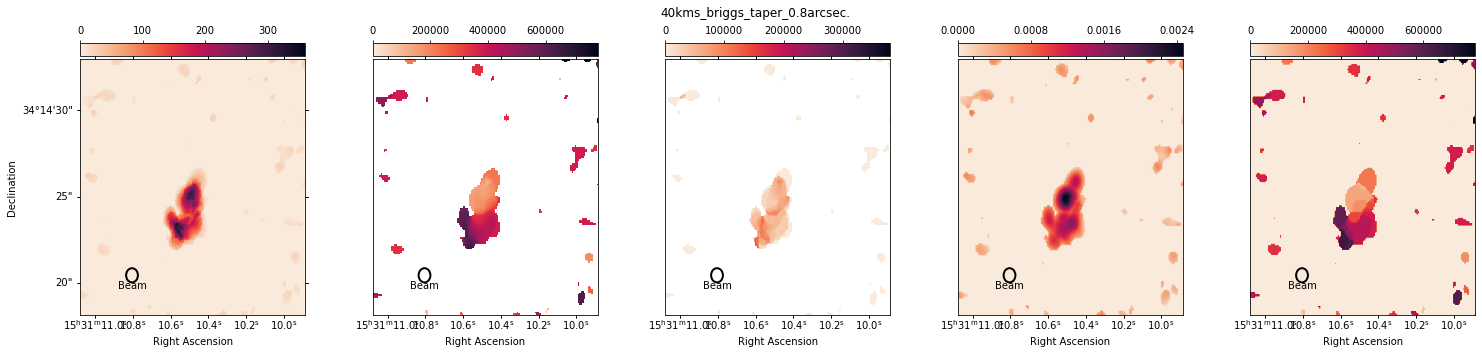

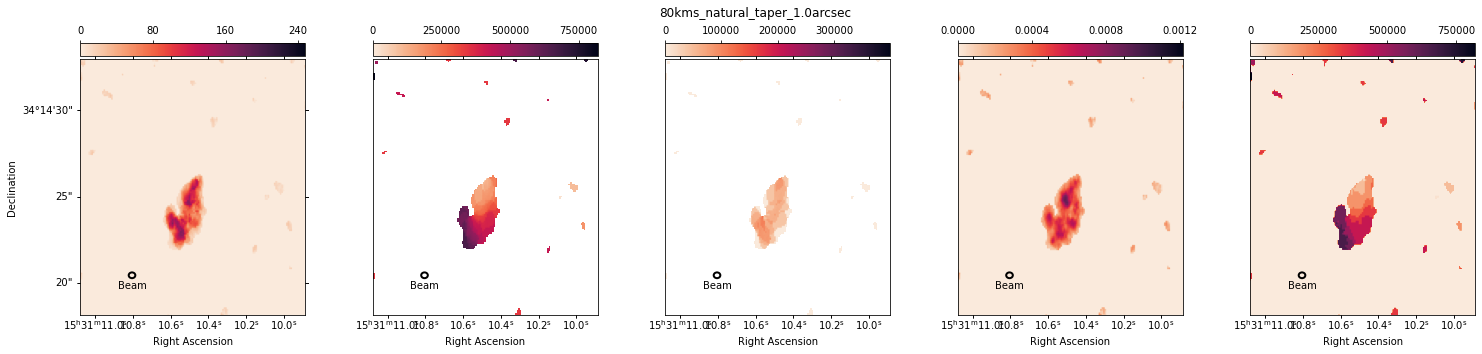

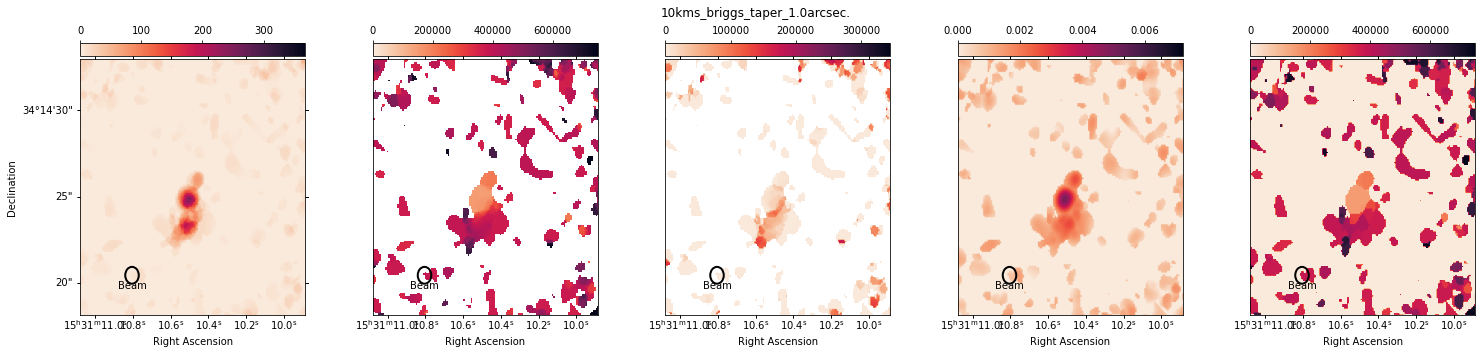

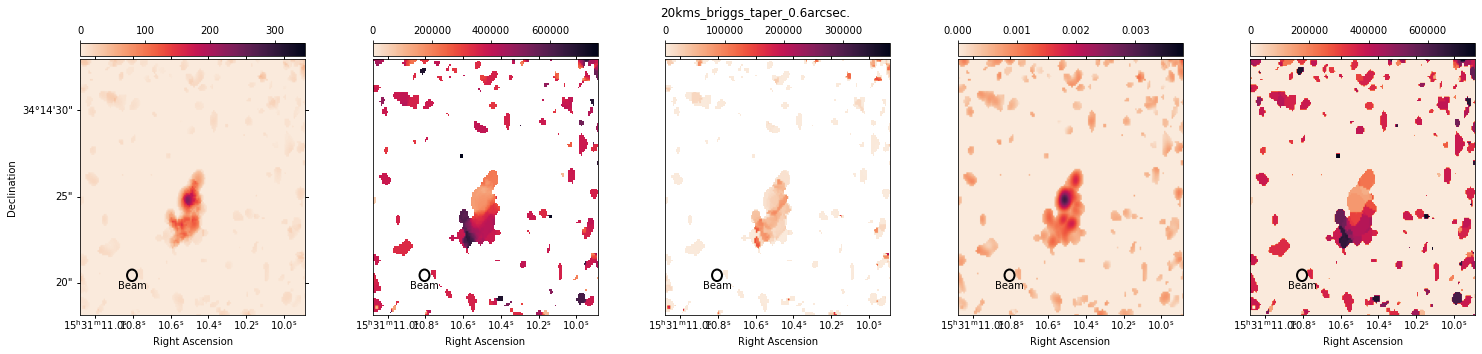

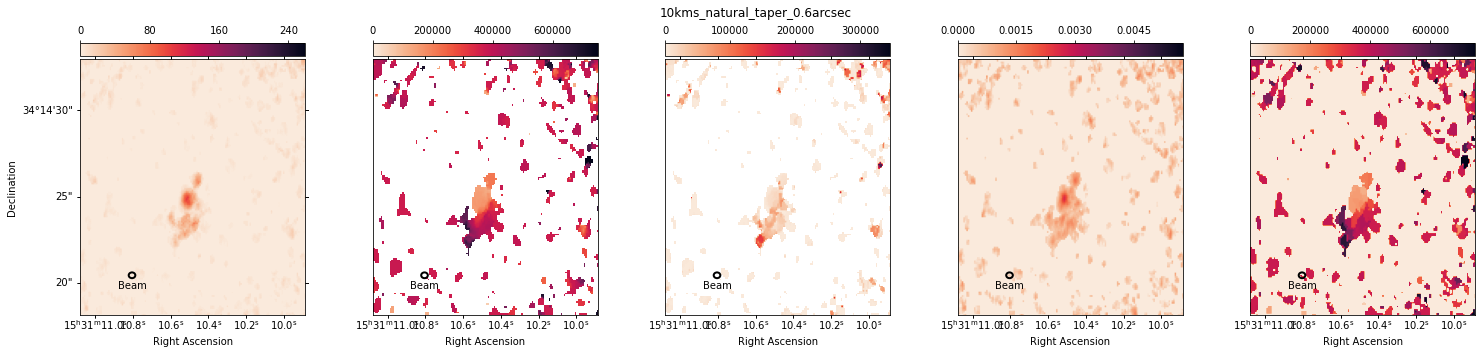

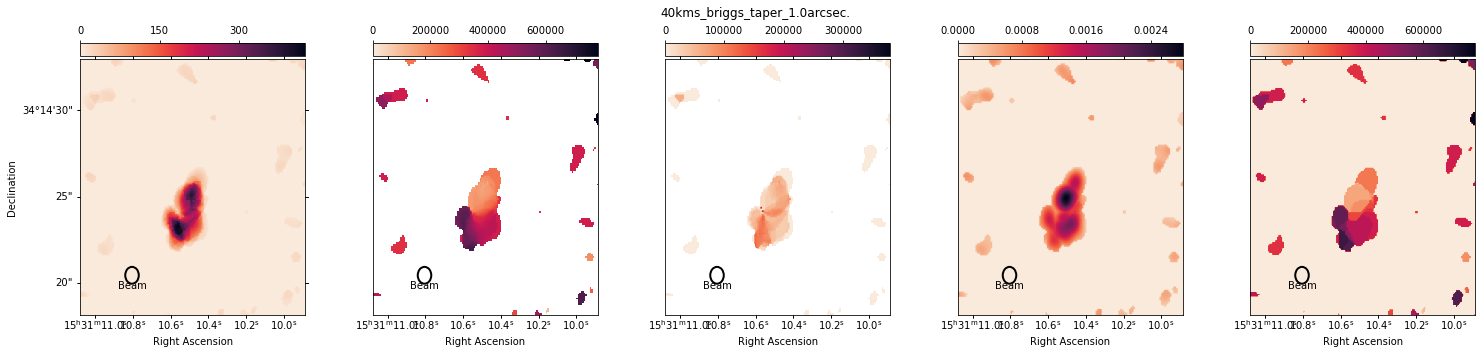

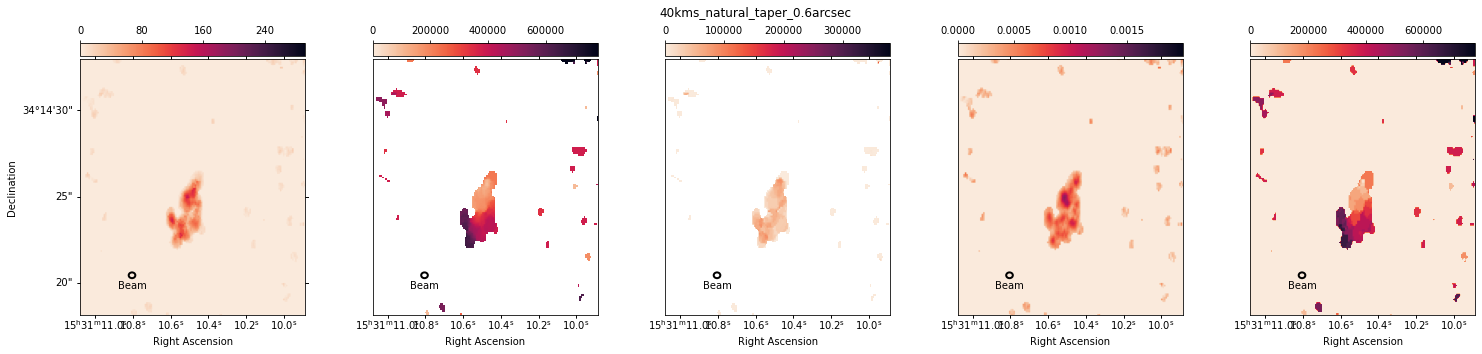

In [20]:
#plot each cube's moments
for mom0_file in mom0_files:
    moment_filenames = [ mom0_file, ''.join((mom0_file[:-6], '1', mom0_file[-5:])), 
                        ''.join((mom0_file[:-6],'2', mom0_file[-5:])), 
                        ''.join((mom0_file[:-6],'8',mom0_file[-5:])), 
                        ''.join((mom0_file[:-6],'9',mom0_file[-5:])) ]

    hdu, header, wcs = pf.open_fits(mom0_file, naxis=2)
    
    fig = pf.plot_all_moments(moment_filenames, header)
    fig.suptitle("{}".format(mom0_file[116:145]))

### The 20km/s natural notaper cube recovers the most emission without having to bin to a higher velocity resolution